## Natural Language Processing


### 1. Create TF-IDF Vectors

In [1]:
import nltk
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
messages['label'] = np.where(messages['label']=='spam', 1, 0)

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

messages['clean_text'] = messages['text'].apply(lambda x: clean_text(x))
messages.head()

,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(messages['clean_text'],
                                                    messages['label'], test_size=0.2)
X_train[:]
y_train[:10]

4763    0
4557    0
2777    0
1181    0
1040    0
2857    0
418     0
610     1
421     1
2967    0
Name: label, dtype: int32

In [13]:
X_train.to_csv('X_train.csv', index=False, header=True)
X_test.to_csv('X_test.csv',index=False, header=True)
y_train.to_csv('y_train.csv',index=False, header=True)
y_test.to_csv('y_test.csv',index=False, header=True)

from sklearn.feature_extraction.text import TfidfVectorizer
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

X_train.head()

,clean_text
0,"['hitechnical', 'supportproviding', 'assistanc..."
1,"['piss', 'talking', 'someone', 'realise', 'u',..."
2,"['kind', 'took', 'garage', 'centre', 'part', '..."
3,"['flippin', 'shit', 'yet']"
4,"['today', 'going', 'college', 'able', 'atten',..."


#### a) Creating TF-IDF Vectors


In [14]:

data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [15]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop =True),
          pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop =True),
          pd.DataFrame(tfidf_test.toarray())], axis=1)
         
X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,7128,7129,7130,7131,7132,7133,7134,7135,7136,7137
0,122,9.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,27,11.1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,372,11.3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,134,9.0,0.12414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,119,5.9,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time

In [17]:
# b) Fit RandomForestClassifier On Top Of Vectors. Evaluate the predictions of the model on the holdout test set

rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print(' Fit time: {}/ Preduct time: {} --- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

 Fit time: 10.509/ Preduct time: 0.323 --- Precision: 0.984 / Recall: 0.858 / Accuracy: 0.979


### 2. Create word2vec Vectors 

In [20]:
# a) Create word2vec Vectors
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100)

In [21]:
messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
messages.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [22]:
# Clean data using the built in cleaner in gensim
messages['text_clean'] = messages['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
messages.head()

,label,text,text_clean
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, until, jurong, point, crazy, available, only, in, bugis, great, world, la, buffet, cine, th..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, in, wkly, comp, to, win, fa, cup, final, tkts, st, may, text, fa, to, to, receive,..."
3,ham,U dun say so early hor... U c already then say...,"[dun, say, so, early, hor, already, then, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though","[nah, don, think, he, goes, to, usf, he, lives, around, here, though]"


In [23]:
# Encoding the label column
messages['label']=messages['label'].map({'ham':1,'spam':0})
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split (messages['text_clean'], messages['label'] , test_size=0.2)

In [24]:
## Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)
w2v_model.wv.index_to_key

['you',
 'to',
 'the',
 'and',
 'in',
 'is',
 'me',
 'my',
 'for',
 'it',
 'your',
 'call',
 'of',
 'that',
 'have',
 'on',
 'now',
 'are',
 'so',
 'can',
 'but',
 'not',
 'we',
 'or',
 'at',
 'do',
 'will',
 'with',
 'be',
 'get',
 'if',
 'ur',
 'no',
 'just',
 'this',
 'how',
 'gt',
 'lt',
 'up',
 'when',
 'ok',
 'free',
 'all',
 'from',
 'go',
 'll',
 'what',
 'out',
 'know',
 'good',
 'am',
 'got',
 'like',
 'then',
 'day',
 'there',
 'its',
 'he',
 'was',
 'time',
 'only',
 'come',
 'love',
 'want',
 'text',
 'send',
 'as',
 'she',
 'need',
 'by',
 'going',
 'one',
 'about',
 'sorry',
 'txt',
 'lor',
 'today',
 'don',
 'stop',
 'back',
 'our',
 'dont',
 'home',
 'hi',
 'still',
 'see',
 'mobile',
 'reply',
 'her',
 'da',
 'please',
 'tell',
 'think',
 'been',
 'phone',
 'take',
 'they',
 'later',
 'pls',
 'any',
 'week',
 'night',
 'did',
 'dear',
 'new',
 'who',
 'has',
 'some',
 'hey',
 'an',
 'here',
 'much',
 're',
 'msg',
 'well',
 'had',
 'him',
 'where',
 'great',
 'claim',

In [47]:
# Find the most similar words to "king" based on word vectors from our trained model
w2v_model.wv.most_similar('like')

[('was', 0.9997405409812927),
 ('there', 0.9997316598892212),
 ('at', 0.9997016191482544),
 ('time', 0.9996972680091858),
 ('not', 0.9996904730796814),
 ('be', 0.9996445775032043),
 ('that', 0.9996353387832642),
 ('can', 0.9996005296707153),
 ('about', 0.9995917081832886),
 ('am', 0.9995807409286499)]

In [48]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

C:\Users\hp\AppData\Local\Temp/ipykernel_16468/22094319.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
C:\Users\hp\AppData\Local\Temp/ipykernel_16468/22094319.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [49]:
for i, v in enumerate(X_train_vect):
    print(len(X_train.iloc[i]), len(v))
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))
        
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

29 29
27 27
7 7
17 16
17 17
14 14
6 5
9 8
9 8
7 7
10 8
1 1
31 27
24 22
6 6
4 4
5 4
4 4
20 19
19 19
9 7
30 30
4 4
5 4
14 13
7 5
12 12
11 11
8 7
29 27
1 1
18 17
7 7
5 5
15 15
35 30
22 22
9 9
17 17
23 21
5 5
7 7
10 10
8 8
29 28
6 6
7 7
20 15
12 10
27 17
8 7
13 13
8 8
9 8
6 6
23 15
13 11
25 23
12 12
19 19
7 7
10 10
7 7
23 19
11 11
20 17
24 24
22 22
10 9
17 16
38 35
24 24
28 27
16 15
7 7
27 27
6 5
7 7
25 25
7 6
9 8
57 56
1 1
11 10
7 6
5 5
12 11
11 8
10 10
21 20
8 8
11 10
11 10
10 10
25 24
8 8
13 11
16 16
9 9
2 2
25 25
5 4
4 4
24 23
29 29
23 20
10 9
1 1
7 3
23 22
11 11
24 22
23 21
30 30
9 9
17 17
26 23
9 9
27 27
27 27
7 7
15 15
9 9
9 9
7 7
6 4
26 26
32 31
8 7
21 15
6 6
21 20
6 5
7 7
6 6
6 6
4 4
5 2
24 24
24 22
14 11
11 11
4 3
35 34
18 18
6 6
2 2
5 5
21 21
5 5
13 12
8 8
13 13
11 11
8 8
3 3
5 4
8 5
67 66
5 5
24 24
6 6
4 4
14 13
7 6
22 22
25 25
23 22
29 29
30 30
21 21
11 10
5 5
6 6
24 21
20 17
26 23
19 18
18 16
22 19
23 23
13 13
6 6
12 10
6 6
12 7
9 9
9 7
13 11
22 19
8 6
22 22
5 5
5 5
4 4
18 17

#### b) Fitting RandomForestClassifier on Top of Word Vectors

In [50]:

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())
y_pred = rf_model.predict(X_test_vect_avg)

from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))



Precision: 0.981 / Recall: 0.984 / Accuracy: 0.969


### 3. Create doc2vec Vectors

In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("spam.csv", encoding = 'latin-1')
data = data.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
data.columns = ["label", "text"]
labels = np.where(data['label']=='spam', 1, 0)

from bs4 import BeautifulSoup

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

data['text'] = data['text'].apply(cleanText)

train, test = train_test_split(data, test_size=0.3, random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [52]:
import nltk

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)

test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)

train_tagged.values[30]

TaggedDocument(words=['as', 'valued', 'customer', 'am', 'pleased', 'to', 'advise', 'you', 'that', 'following', 'recent', 'review', 'of', 'your', 'mob', 'no', 'you', 'are', 'awarded', 'with', 'å£1500', 'bonus', 'prize', 'call', '09066364589'], tags=['spam'])

#### b) Fit RandomForestClassifier On Top Of Document Vectors


In [53]:

# Set-up Doc2Vec Training & Evaluation Models

import multiprocessing
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

# Building the Final Vector Feature for the Classifier

def vec_for_learning(model, tagged_docs):
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in tagged_docs.values])
    return targets, regressors 

# Train the Logistic Regression Classifier.

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

100%|██████████████████████████████████████████████████████████████████████████| 3900/3900 [00:00<00:00, 810674.28it/s]


Testing accuracy 0.8989234449760766
Testing F1 score: 0.8699501820848415


### 4. Build And Evaluate RNN

In [56]:
from keras.preprocessing.text import Tokenizer # simple pre-process function from genesis celan and tokenize our data
from keras_preprocessing.sequence import pad_sequences

data = pd.read_csv("spam.csv", encoding = 'latin-1')
data.head()
data = data.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
data.columns = ["label", "text"]
# converting the labels is numeric format

labels = np.where(data['label']=='spam', 1, 0)
X_train, X_test, y_train, y_test = train_test_split(data['text'],
                                                    labels, test_size=0.2)
get_ipython().system('pip install keras==2.6')

# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Use that tokenizer to transform the text messages in the training and test sets

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

     ---------------------------------------- 1.3/1.3 MB 315.4 kB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.6.0 which is incompatible.


In [59]:
X_train_seq[0]
# Pad the sequences so each sequence is the same length

X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)
X_train_seq_padded[0]

# **Build Model**
# Import the tools needed from keras and define functions to calculate recall and precision

import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [60]:
# Construct a simple RNN model

model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compile the model

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

# Fit the RNN model

history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          253504    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 262,913
Trainable params: 262,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: clos

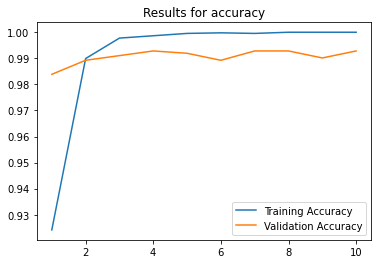

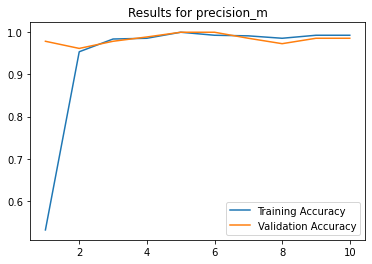

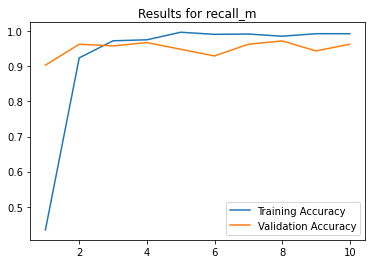

In [61]:
# b) Evaluating Results

import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

### 5. compare the results(key value metrics)

In [62]:
# a)summarize all technique's results.

# (a) RNN Output
# 
# Precision_m: 0.9929 
# 
# Recall_m: 0.9929 
# 
# val_loss: 0.0461 
# 
# val_accuracy: 0.9928 
# 
# val_precision_m: 0.9857 
# 
# val_recall_m: 0.9629
#----------------------------------------------------------
# (b) TF-IDF Output
#
# Precision: 0.984 
# 
# Recall: 0.858 
# 
# Accuracy_score: 0.979
#----------------------------------------------------------
# (c) word2vec Output
# 
# Precision: 0.981 
# 
# Recall: 0.984 
# 
# Accuracy: 0.969
#---------------------------------------------------------
# (d) doc2vec Output
# 
# Testing accuracy 0.8989234449760766
# 
# Testing F1 score: 0.8699501820848415
#---------------------------------------------------------

In [63]:
# b)explain which technique is best and why ?

# From the 4 models which we implemented , it can be concluded that RNN gave us the best results. Whereas, TF-IDF and WORD2VEC gave almost the same accuracy.
#------------------------------------------------------------
#  RNN      - 0.9920
# 
#  TF-IDF   - 0.9677
# 
#  WORD2VEC - 0.9670
# 
#  DOC2VEC  - 0.9001
#-------------------------------------------------------------
# **Thus RNN gave the highest accuracy of 99.19%** 